## Data processing description

### Hello Carlton!

This is a step-by-step description how I am calculating data for CarltonIndex.

Hopefully this helps us to settle a desired data processing algorithm.

I tried to make this code simple and clear. I am explaining what I am doing in comments and I am showing intermediate results after each step.

I am using DAILY data because we will need to show a fresh data on the Collective2 pages every day.

Let's get an arbitrary system as an example: https://collective2.com/details/123071731

In [59]:
# Load packages and helper functions used in calculations
source("utils.R")

strategyId = 123071731

[1] "Initialization done"


In [60]:
# ==================================================
# Get daily equity data from the C2 database
# ==================================================
dbData = readData(strategyId)

# Show a sample of data we have
head(dbData,n=10)
tail(dbData)   

,dateTime,value
,<chr>,<dbl>
1,2019-03-26 00:00:00,31477.00
2,2019-03-27 00:00:00,32998.68
3,2019-03-28 00:00:00,33515.56
4,2019-03-29 00:00:00,33501.78
5,2019-03-30 00:00:00,33501.78
6,2019-03-31 00:00:00,33504.78
7,2019-04-01 00:00:00,33407.74
8,2019-04-02 00:00:00,33132.38
9,2019-04-03 00:00:00,33726.10


,dateTime,value
,<chr>,<dbl>
557,2020-10-02 00:00:00,58719.96
558,2020-10-03 00:00:00,58719.96
559,2020-10-04 00:00:00,58719.96
560,2020-10-05 00:00:00,58719.96
561,2020-10-06 00:00:00,58719.96
562,2020-10-07 00:00:00,58719.96


In [61]:
# Convert data to time series structure for further processing. This operation does not change any values.
series = transformDataToTimeSeries(dbData)

# ----------------------------------------------------------------------------------------
# Calculate returns. 
# We can have "log" or "discrete" returns representation. 
# Let's get "discrete": (Return2 - Return1) / Return1
# ----------------------------------------------------------------------------------------

# --------------------------------------------
# let's describe and debug returns calculation 
# --------------------------------------------
debugseries = as.numeric(series); len = length(debugseries)
# The first return should be: (secondVal - firstVal) / firstVal
firstReturn = (debugseries[2] - debugseries[1]) / debugseries[1]
print(sprintf("The first return should be %.8f",firstReturn))


[1] "The first return should be 0.04834260"


In [62]:
# ----------------------------------------------------------------------------------------
# Calculate daily returns. 
# ----------------------------------------------------------------------------------------
returns = CalculateReturns(series, method = "discrete")
# Remove the first value which is undefined (NA)
returns =  returns[-1]

# Show first and last data we have now
head(returns)
tail(returns) 


                   Close
2019-03-27  4.834260e-02
2019-03-28  1.566366e-02
2019-03-29 -4.111523e-04
2019-03-30  0.000000e+00
2019-03-31  8.954748e-05
2019-04-01 -2.896303e-03

                 Close
2020-10-02 0.003011428
2020-10-03 0.000000000
2020-10-04 0.000000000
2020-10-05 0.000000000
2020-10-06 0.000000000
2020-10-07 0.000000000

In [63]:
# Calculate actual 30-days performance from returns.

# ------------------------------------------------------
# let's debug it a little and verify apply.rolling command results below:
print(sprintf("The first 30-days return should be %.7f", ( debugseries[30]-debugseries[1]) / debugseries[1]) )
print(sprintf("The last 30-days return should be %.7f",  ( debugseries[len]-debugseries[len-30]) / debugseries[len-30]))

[1] "The first 30-days return should be 0.1826362"
[1] "The last 30-days return should be 0.0327421"


In [64]:
# Calculate actual 30-days performance from returns.
return30 = apply.rolling(series, width=30, FUN = function(eq) { (eq[30] - eq[1]) / eq[1] })

# Remove undefined rows
return30 = na.omit(return30); colnames(return30) = "Return30"

# Show what we have:
head(return30)
tail(return30)

            Return30
2019-04-24 0.1826362
2019-04-25 0.1311071
2019-04-26 0.1107163
2019-04-27 0.1111732
2019-04-28 0.1111732
2019-04-29 0.1189669

             Return30
2020-10-02 0.07742453
2020-10-03 0.03274210
2020-10-04 0.03274210
2020-10-05 0.03274210
2020-10-06 0.03274210
2020-10-07 0.03274210

In [65]:
# Calculate rolling standard deviation in time windows.

SD_TIME_WINDOW_LEN_DAYS = 21

sd_time_win = apply.rolling(returns, width=SD_TIME_WINDOW_LEN_DAYS, FUN = function(R) { sd(R) } ); 

# Remove first undefined values from data
sd_time_win = na.omit(sd_time_win) #; colnames(sd_time_win) = "SD_TW"

# Carlton: Annualized SD = SD for 21 Days worth of returns * SqRt (365)
sd_time_win = sd_time_win * sqrt(365)
colnames(sd_time_win) = "SD_TW_ANN"

# Show what we have
head(sd_time_win)
tail(sd_time_win)

           SD_TW_ANN
2019-04-16 0.2282062
2019-04-17 0.1410407
2019-04-18 0.1336144
2019-04-19 0.1331908
2019-04-20 0.1331908
2019-04-21 0.1332141

            SD_TW_ANN
2020-10-02 0.07694488
2020-10-03 0.07694488
2020-10-04 0.07694488
2020-10-05 0.07694488
2020-10-06 0.07694488
2020-10-07 0.07694488

In [66]:
# Bind data together by dates and show what we have.
data = bindDataTogether(series,return30,sd_time_win)

head(data)
tail(data)

date,Close,Return30,SD_TW_ANN
<dttm>,<dbl>,<dbl>,<dbl>
2019-04-24,37225.84,0.1826362,0.10534705
2019-04-25,37325.04,0.1311071,0.08538509
2019-04-26,37226.28,0.1107163,0.08746370
2019-04-27,37226.28,0.1111732,0.08746370
2019-04-28,37226.28,0.1111732,0.08859891
2019-04-29,37490.74,0.1189669,0.08229651


date,Close,Return30,SD_TW_ANN
<dttm>,<dbl>,<dbl>,<dbl>
2020-10-02,58719.96,0.07742453,0.07694488
2020-10-03,58719.96,0.03274210,0.07694488
2020-10-04,58719.96,0.03274210,0.07694488
2020-10-05,58719.96,0.03274210,0.07694488
2020-10-06,58719.96,0.03274210,0.07694488
2020-10-07,58719.96,0.03274210,0.07694488


            Return30  SD_TW_ANN
2019-04-24 0.1826362 0.22820619
2019-04-24 0.1826362 0.07796484
2019-04-25 0.1311071 0.14104070
2019-04-25 0.1311071 0.07677082
2019-04-26 0.1107163 0.13361443
2019-04-26 0.1107163 0.07694488

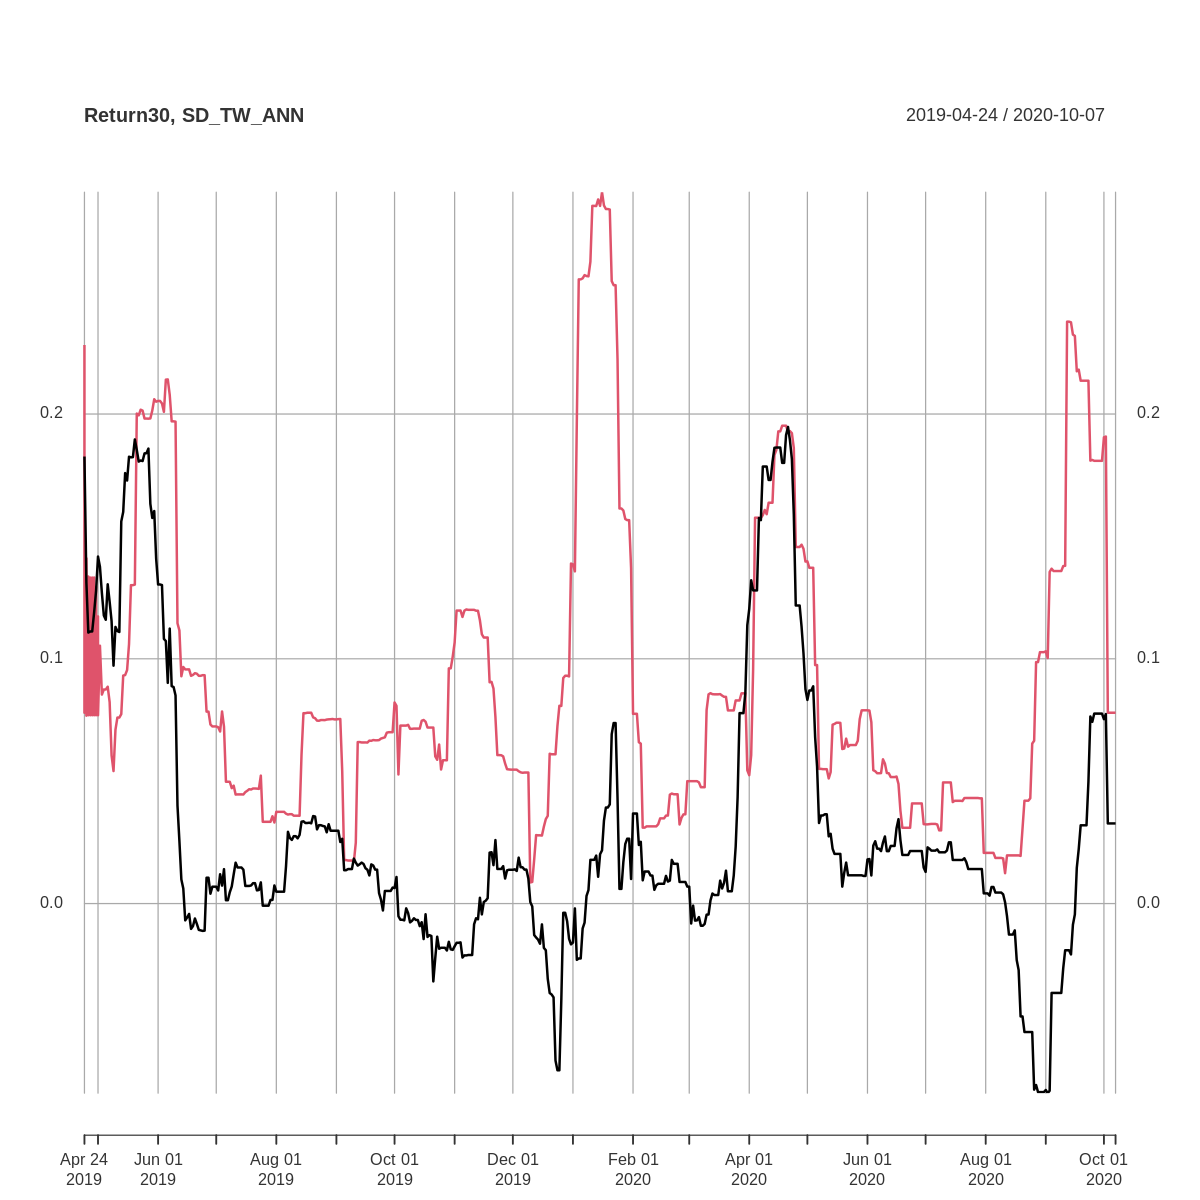

In [98]:
# Visualize what we have
statsData <- as.xts.data.table(data[,list(date, Return30, sd_time_win)])
colnames(statsData) = c("Return30","SD_TW_ANN")
options(repr.plot.width=10, repr.plot.height=10)
plot(statsData,main = "Return30, SD_TW_ANN")
head(statsData)

## Proforma returns

In [99]:
# ----------------------------------
# Proforma Returns - see Slack https://collective2.slack.com/archives/CH97NLREC/p1602475461280100
# ----------------------------------

# ProForma Sept 30, 2020 Return = Actual Sept 30, 2020 Return * 10% / (Annualized SD of Daily Return (Sept 10-30));
# ProForma Sept 29, 2020 Return = Actual Sept 29, 2020 Return * 10% / (Annualized SD of Daily Returns (Sept 9-29));
# Where 
#    Annualized SD = SD for 21 Days worth of returns * SqRt (365) 
#    which we have it already in the SD_TW_ANN column

proformaReturns = statsData
proformaReturns$ProformaRet = proformaReturns$Return30 * 0.1 / proformaReturns$SD_TW_ANN

head(proformaReturns)
tail(proformaReturns)

            Return30  SD_TW_ANN ProformaRet
2019-04-24 0.1826362 0.22820619  0.08003122
2019-04-24 0.1826362 0.07796484  0.23425457
2019-04-25 0.1311071 0.14104070  0.09295690
2019-04-25 0.1311071 0.07677082  0.17077721
2019-04-26 0.1107163 0.13361443  0.08286256
2019-04-26 0.1107163 0.07694488  0.14389045

             Return30  SD_TW_ANN ProformaRet
2020-10-02 0.07742453 0.19079803  0.04057931
2020-10-03 0.03274210 0.07796484  0.04199598
2020-10-04 0.03274210 0.07796484  0.04199598
2020-10-05 0.03274210 0.07796484  0.04199598
2020-10-06 0.03274210 0.07796484  0.04199598
2020-10-07 0.03274210 0.07796484  0.04199598

            Return30 ProformaRet
2019-04-24 0.1826362  0.08003122
2019-04-24 0.1826362  0.23425457
2019-04-25 0.1311071  0.09295690
2019-04-25 0.1311071  0.17077721
2019-04-26 0.1107163  0.08286256
2019-04-26 0.1107163  0.14389045

             Return30 ProformaRet
2020-10-02 0.07742453  0.04057931
2020-10-03 0.03274210  0.04199598
2020-10-04 0.03274210  0.04199598
2020-10-05 0.03274210  0.04199598
2020-10-06 0.03274210  0.04199598
2020-10-07 0.03274210  0.04199598

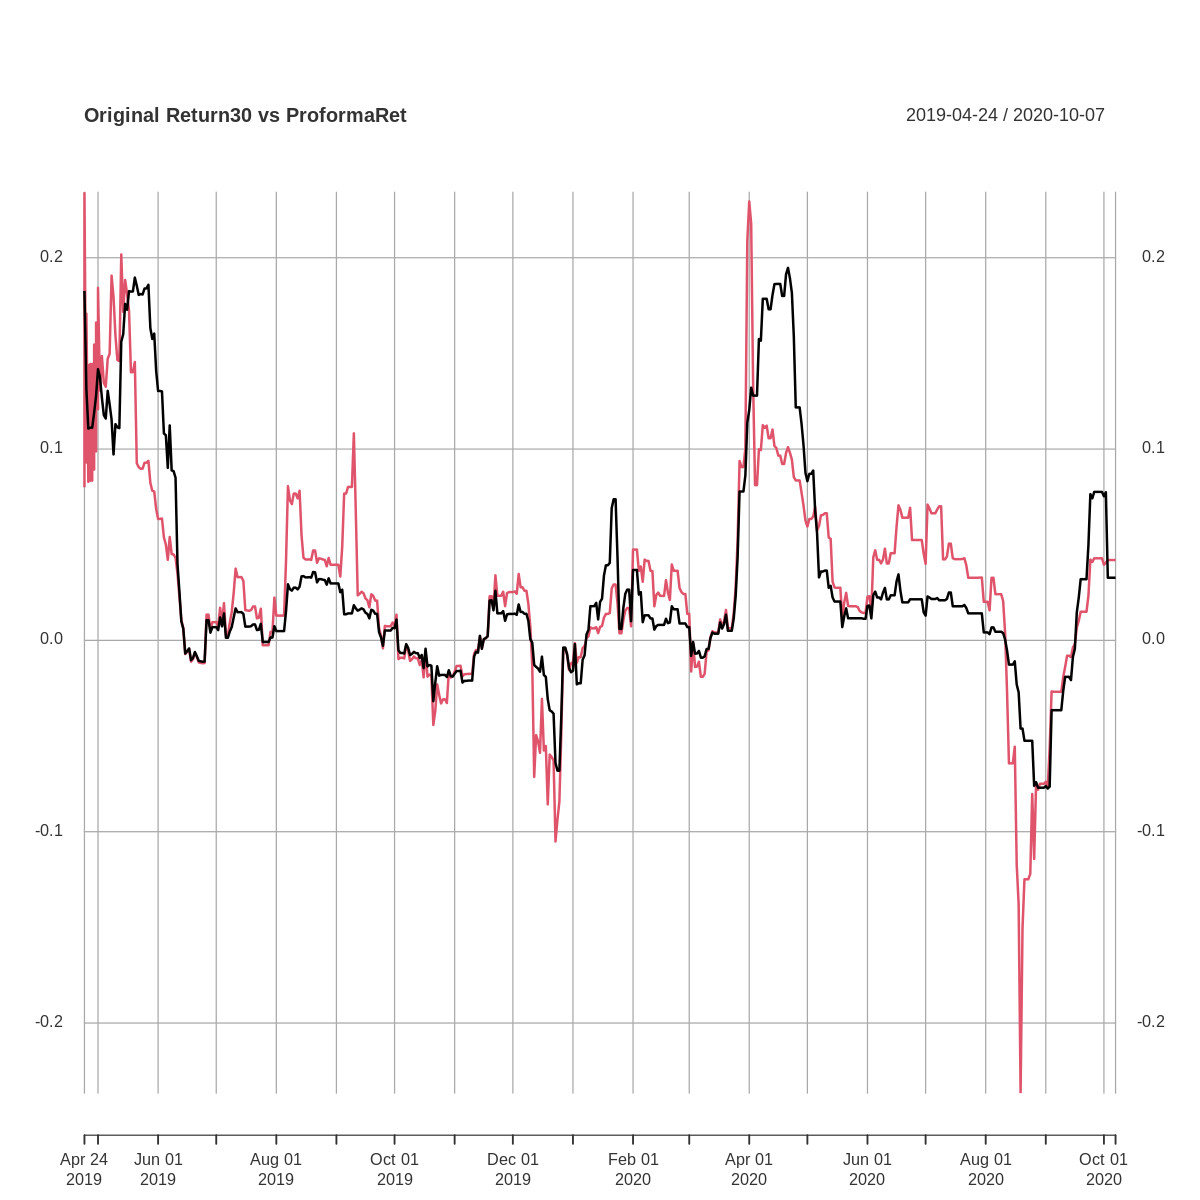

In [101]:
# Visualize Proforma and original system equity returns
vis = proformaReturns[,c("Return30","ProformaRet")] 
plot(vis, main="Original Return30 vs ProformaRet")
head(vis)
tail(vis)

# Rolling 210 days proforma returns

           ProformaAnnReturn
2019-11-11          15.28671
2019-11-12          15.13891
2019-11-13          14.72241
2019-11-14          14.56441
2019-11-15          14.26061
2019-11-16          14.11763

           ProformaAnnReturn
2020-10-02          10.76000
2020-10-03          10.86604
2020-10-04          10.97209
2020-10-05          11.07544
2020-10-06          11.15837
2020-10-07          11.24043

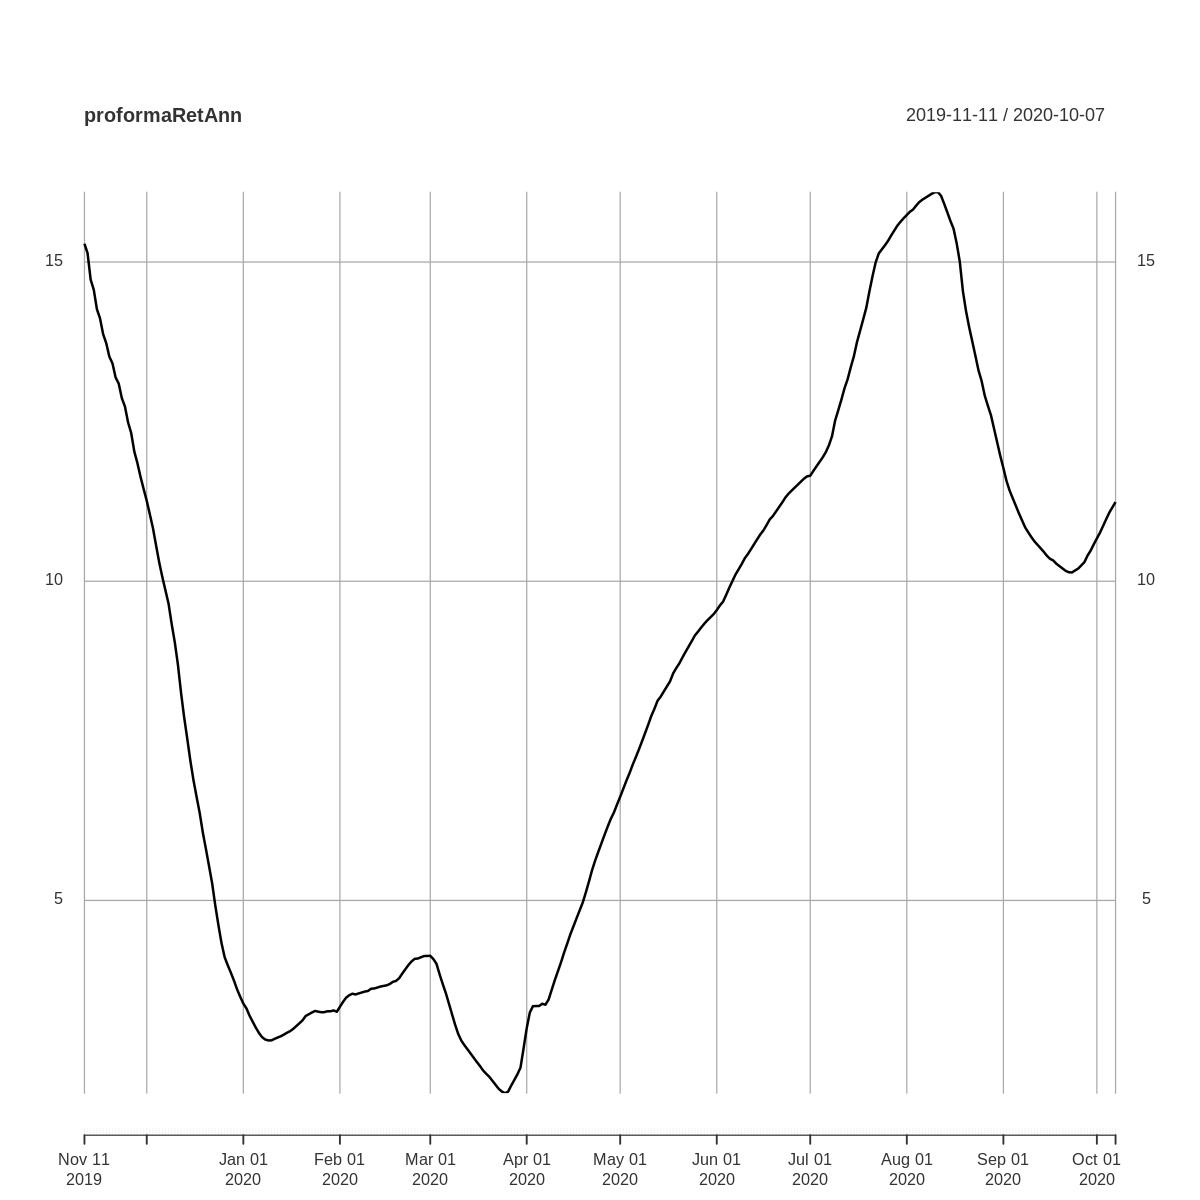

In [105]:
ROLLING_WINDOW = 210

proformaRetAnn = apply.rolling(proformaReturns$ProformaRet, width=ROLLING_WINDOW, FUN = function(R) { mean(R) * 365} )

# Remove first undefined rows
proformaRetAnn = na.omit(proformaRetAnn); colnames(proformaRetAnn) = "ProformaAnnReturn"

# Show what we have:
head(proformaRetAnn)
tail(proformaRetAnn)

plot(proformaRetAnn)